## Noise Variance on W across datasets
This is the very first version of Variance Decomposition and what would be the integration weights based on that

In [1]:
import init_paths
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import cortico_cereb_connectivity.evaluation as ev
import Functional_Fusion.dataset as fdata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
def calc_var_df(train_types):
    var_dic = {'eval_dataset': [],
               'logalpha': [],
               'eval_subj': [],
               'coef_var': [],
               'coef_norm': [],
               'sig_norm': [],
               'coef_var_g': [],
               'coef_var_s': [],
               'coef_var_m': [],
               'reliability': []}
    for dataset_name, (ses, la) in train_types.items():
        config = rm.get_eval_config(eval_dataset=dataset_name, eval_ses=ses, model='ind', cerebellum='MNISymC3', add_rest=True)
        dataset = fdata.get_dataset_class(gl.base_dir, dataset=dataset_name)
        config["subj_list"] = dataset.get_participants().participant_id
        S = len(config['subj_list'])

        dirname=[]
        mname=[]
        for a in la:
            dirname.append(f"{dataset_name}_{ses}_Icosahedron1002_L2reghalf")
            mname.append(f"{dataset_name}_{ses}_Icosahedron1002_L2reghalf_A{a}")

        fm,_ = rm.get_fitted_models(dirname,mname,config)
        for a, alpha in enumerate(la):
            n_vox, n_region = fm[a][0].coef_.shape
            coef_1 = np.stack([fm[a][s].coef_1 for s in range(S)], axis=0)
            coef_2 = np.stack([fm[a][s].coef_2 for s in range(S)], axis=0)

            vg, vs, vm = rm.decompose_variance_half(np.stack((coef_1, coef_2), axis=1))
            for s in range(S):
                coef_norm = np.linalg.norm(np.nan_to_num(fm[a][s].coef_))
                sig_norm2 = coef_norm**2 - n_vox*n_region*(vs[s]+vm[s]/2)
                var_dic['coef_var'].append(vs[s]+vm[s]/2)
                var_dic['coef_norm'].append(coef_norm)
                var_dic['sig_norm'].append(np.sqrt(sig_norm2))
                data = np.concatenate([fm[a][s].coef_1.T, fm[a][s].coef_2.T], axis=0)
                dataframe = pd.DataFrame({'half': np.repeat([1,2], fm[a][s].coef_1.shape[1])})
                R, _, _, _ = ev.calculate_reliability(data, dataframe)
                var_dic['reliability'].append(R)
            var_dic['coef_var_g'].extend(vg)
            var_dic['coef_var_s'].extend(vs)
            var_dic['coef_var_m'].extend(vm)
            var_dic['eval_subj'].extend(config["subj_list"])
            var_dic['logalpha'].extend([alpha]*S)
        var_dic['eval_dataset'].extend([dataset_name]*(len(var_dic['eval_subj'])-len(var_dic['eval_dataset'])))

    var_df = pd.DataFrame(var_dic)
    var_df['subj_id'] = var_df['eval_subj']
    var_df['train_dataset'] = var_df['eval_dataset']
    var_df['effective_weight'] = var_df['sig_norm'] / var_df['coef_var']
    var_df['contribution'] = var_df['effective_weight'] * var_df['coef_norm']
    return var_df

In [2]:
dataset_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto"]
best_la = [4, 6, 2, 6, 2, 8]
train_types = {}
for d, dataset_name in enumerate(dataset_list):
    if dataset_name == 'Language':
        train_types[dataset_name] = ('ses-localizer_cond', [best_la[d]])
    else:
        train_types[dataset_name] = ('all', [best_la[d]])

In [29]:
var_df = calc_var_df(train_types)
var_df.to_csv('/home/ROBARTS/ashahb7/Github/bayes_temp/decom_var_df.tsv', sep='\t', index=False)

/home/ROBARTS/ashahb7/Github/cortico_cereb_connectivity/cortico_cereb_connectivity/run_model.py:1032: RuntimeWarning: invalid value encountered in sqrt
  vg = np.nansum(np.sqrt(SS_2[:, None] / SS_2) * SS_1, axis=1) / (n_sub-1)    # Shape: (n_sub)


In [3]:
var_df = pd.read_csv('/home/ROBARTS/ashahb7/Github/bayes_temp/decom_var_df.tsv', sep='\t')

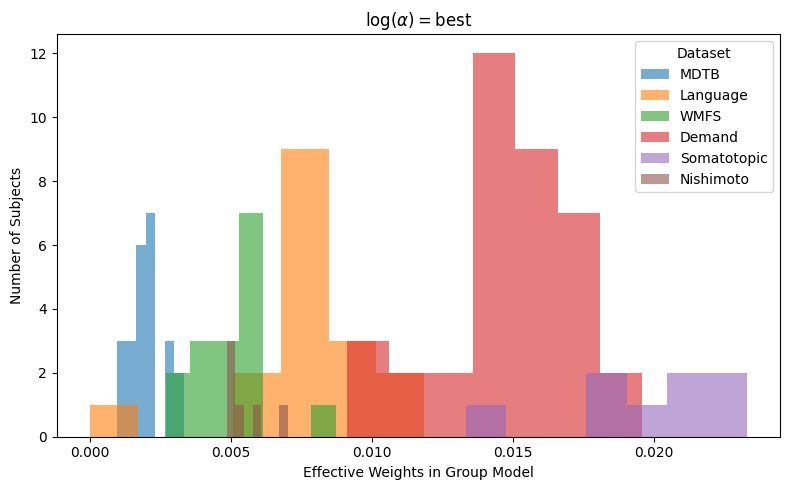

In [31]:
plt.figure(figsize=(8,5))
all_weights = np.sum(var_df.effective_weight)
for dataset_name in dataset_list:
    plt.hist(var_df[var_df.train_dataset == dataset_name].effective_weight / all_weights, bins=7, alpha=0.6, label=dataset_name)
plt.xlabel('Effective Weights in Group Model')
plt.ylabel('Number of Subjects')
plt.legend(title='Dataset')
plt.title(r'$\log(\alpha)=$best')
plt.tight_layout()
plt.show()

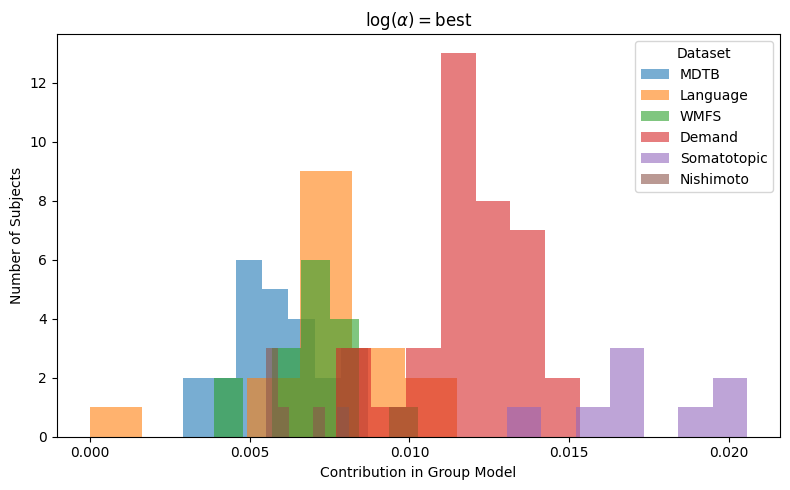

In [32]:
plt.figure(figsize=(8,5))
all_contribution = np.sum(var_df.contribution)
for dataset_name in dataset_list:
    plt.hist(var_df[var_df.train_dataset == dataset_name].contribution / all_contribution, bins=7, alpha=0.6, label=dataset_name)
plt.xlabel('Contribution in Group Model')
plt.ylabel('Number of Subjects')
plt.legend(title='Dataset')
plt.title(r'$\log(\alpha)=$best')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Contribution of each Dataset')

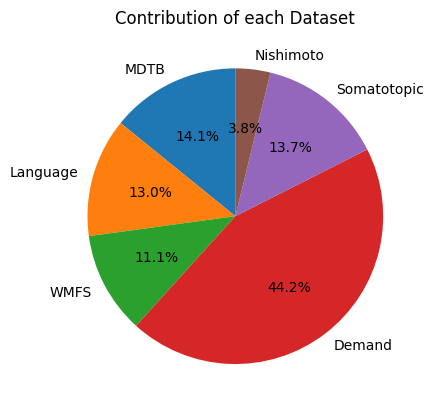

In [33]:
plt.pie(var_df.groupby('train_dataset')['contribution'].sum().reindex(dataset_list), labels=dataset_list, autopct='%1.1f%%', startangle=90)
plt.title('Contribution of each Dataset')

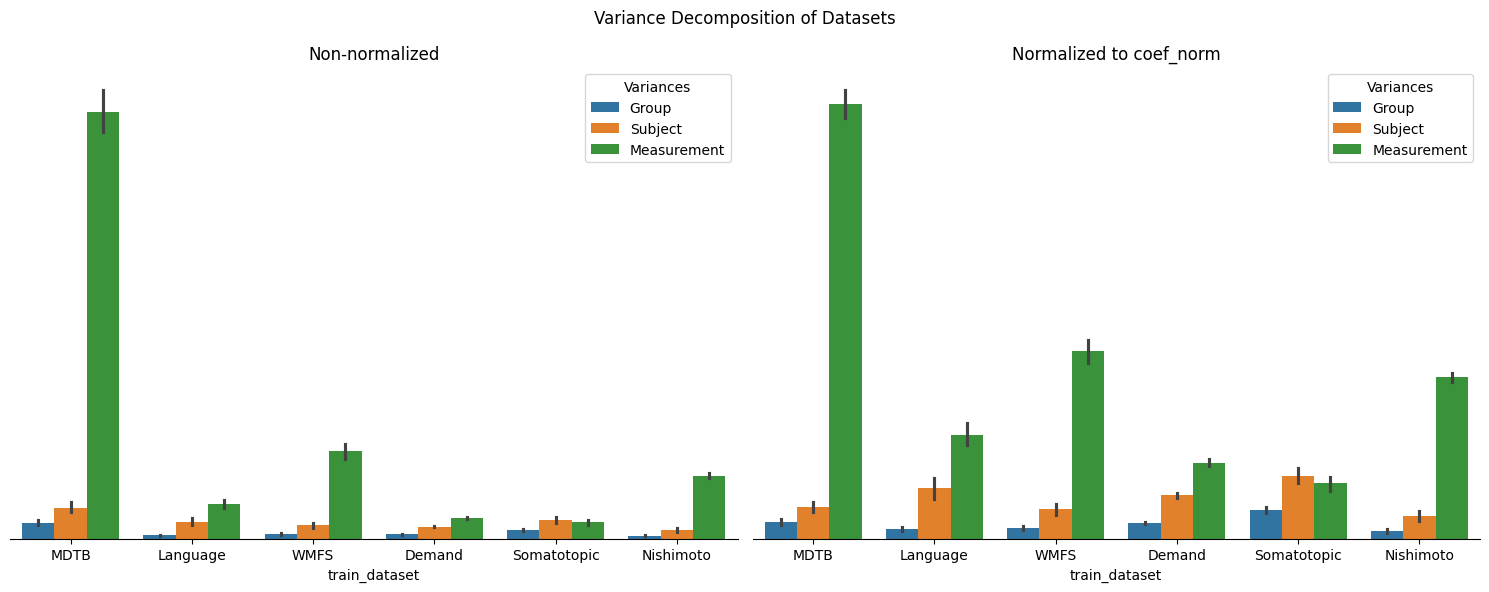

In [5]:
vars = ['coef_var_g', 'coef_var_s', 'coef_var_m']
decom_df = var_df[['train_dataset', 'coef_var_g', 'coef_var_s', 'coef_var_m']].copy()
decom_df['coef_var_m'] /= 2
norm_decom_df = decom_df.copy()
norm_decom_df[['coef_var_g', 'coef_var_s', 'coef_var_m']] = decom_df[['coef_var_g', 'coef_var_s', 'coef_var_m']].div(var_df['coef_norm'], axis=0)
decom_df['normalized'] = False
norm_decom_df['normalized'] = True
decom_df = pd.concat([decom_df, norm_decom_df], ignore_index=True)

fig, axes = plt.subplots(1,2,figsize=(15,6))
for i,norm_type in enumerate([False, True]):
    # df_pivot = pd.pivot_table(decom_df[decom_df['normalized']==norm_type], index='train_dataset', values=vars, aggfunc='mean')
    # df_pivot = df_pivot.reindex(dataset_list)
    # df_pivot = df_pivot[vars]
    df_decom_melt = decom_df[decom_df['normalized']==norm_type].melt(id_vars=['train_dataset'], value_vars=vars, var_name='Variances', value_name='value')

    ax = plt.subplot(1,2,i+1)
    sns.barplot(df_decom_melt, x='train_dataset', y='value', hue='Variances', ax=ax)
    
    # ax = plt.subplot(2,2,i+1)
    # df_pivot.plot(kind='bar', stacked=True, ax=ax)

    if i==0:
        ax.set_title('Non-normalized')
    else:
        ax.set_title('Normalized to coef_norm')
for ax in axes.flatten():
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.legend(handles=handles, labels=['Group', 'Subject', 'Measurement'], title='Variances')
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
plt.suptitle('Variance Decomposition of Datasets')
plt.tight_layout()

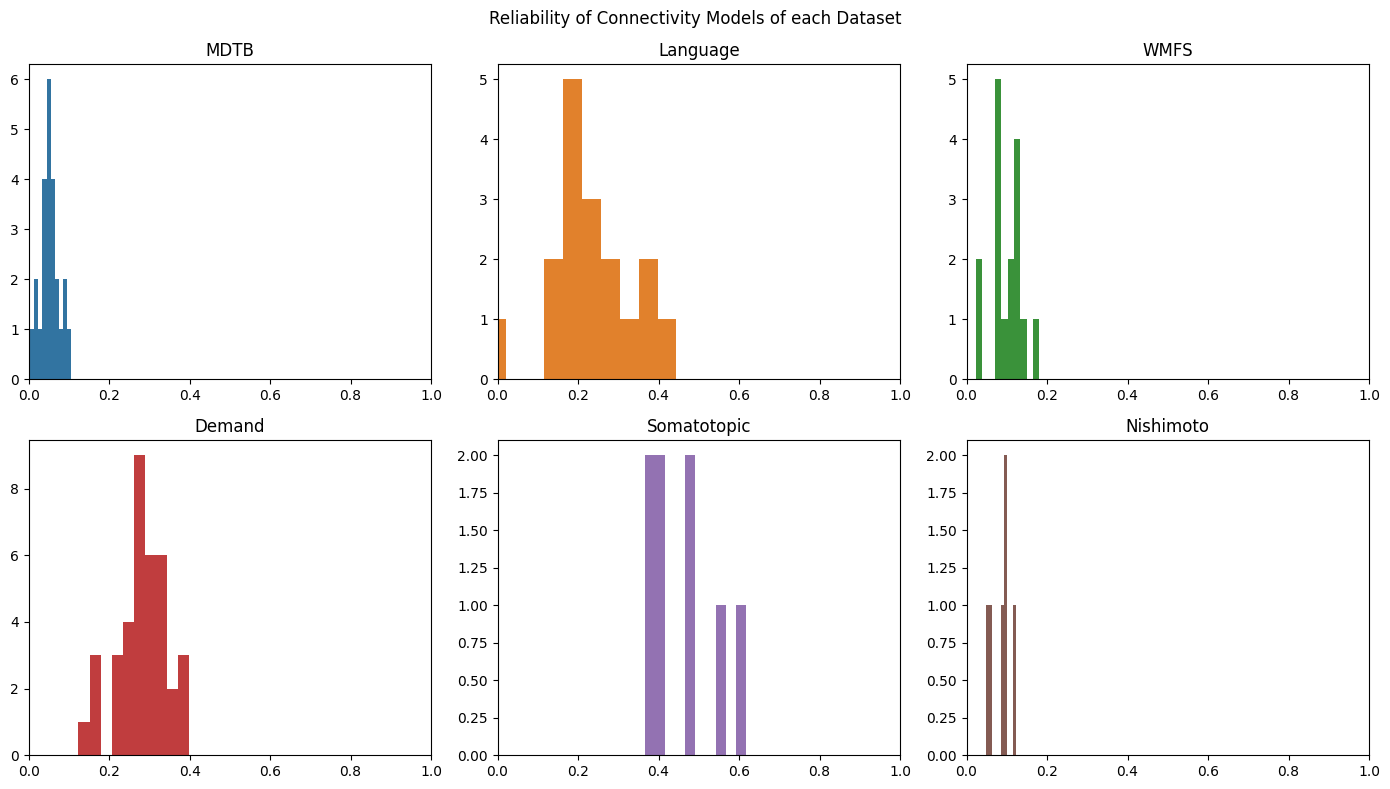

In [39]:
plt.subplots(int(np.ceil(len(dataset_list)/3)),3,figsize=(14,int(np.ceil(len(dataset_list)/3))*4))
plt.suptitle('Reliability of Connectivity Models of each Dataset')
colors = sns.color_palette("tab10", desat=0.75)
for d,dataset in enumerate(dataset_list):
    plt.subplot(int(np.ceil(len(dataset_list)/3)),3,d+1)
    df_to_eval = var_df[var_df['train_dataset'] == dataset]
    plt.hist(df_to_eval.reliability, color=colors[d])
    plt.xlim([0, 1])
    plt.title(dataset)
plt.tight_layout()